# When Shapley Values Break: A Guide to Robust Model Explainability

**Based on:** [Alon Lanyado's article on Towards Data Science](https://towardsdatascience.com/when-shapley-values-break-a-guide-to-robust-model-explainability/) (Jan 2026)

---

## What You'll Learn

Shapley values (via SHAP) are the **gold standard** for model explainability — they provide a mathematically rigorous way to attribute each feature's contribution to a prediction. But they have a critical weakness: **when features are correlated or duplicated, Shapley values dilute the signal**, hiding the true drivers of your model behind a wall of redundancy.

In this notebook, we'll:
1. Build a **toy linear model** where we know the ground truth contributions
2. **Break Shapley values** by introducing duplicated/correlated features
3. Fix the problem with **Direct Group Shapley** — treating groups of related features as single players
4. Fix it further with **Greedy Iterative Selection** — a "Winner Takes It All" approach that strips redundancy
5. Apply everything to a **healthcare dataset** inspired by the CMS AI Health Outcomes Challenge

### The Core Insight

In game theory, the Shapley value fairly distributes a "payout" among players based on their marginal contributions across all possible coalitions. For ML:
- **Players** = features
- **Payout** = model prediction (minus baseline)
- **Coalition** = a subset of features used to make a prediction

The formula:

$$\phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|!(|N|-|S|-1)!}{|N|!} \left[ v(S \cup \{i\}) - v(S) \right]$$

Where $v(S)$ is the model's prediction using only features in coalition $S$.

**The problem:** When features carry the same information (correlated/duplicated), Shapley values "fairly" split credit among them. This is mathematically correct but practically misleading — it hides which feature is the true driver.

## Setup & Dependencies

In [42]:
# Install dependencies if needed
# !pip install numpy pandas scikit-learn shap xgboost matplotlib seaborn

In [ ]:
# Import package
import warnings
from itertools import combinations
from math import factorial

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.linear_model import LinearRegression

warnings.filterwarnings('ignore')

np.random.seed(42)
print("All imports successful!")

All imports successful!


---
## Part 1: Toy Model — Independent Features (Ground Truth)

We start with the simplest possible scenario: a **linear model with independent features**.

For a linear model $f(x) = w_1 x_1 + w_2 x_2 + ... + w_n x_n + b$, when features are independent, the theoretical Shapley value for feature $i$ on a data point $x$ is:

$$\phi_i(x) = w_i \cdot (x_i - \mathbb{E}[X_i])$$

This is our **ground truth** — if SHAP gives us anything different from this, something is wrong.

In [44]:
def get_shapley_values_linear_independent(weights, data, means):
    """
    Theoretical Shapley values for a linear model with independent features.

    For independent features in a linear model, the Shapley value for feature i
    is simply: weight_i * (x_i - E[x_i])

    This is our ground truth to compare SHAP library output against.
    """
    return weights * (data - means)

In [45]:
# Generate 5 independent uniform random features
n_samples = 10000
n_features = 5

X = np.random.uniform(0, 1, size=(n_samples, n_features))

# Create known weights — all features have non-zero weights
true_weights = np.array([10.0, 5.0, 3.0, 1.0, 0.5])

# Generate target: y = X @ weights (no noise, perfect linear relationship)
y = X @ true_weights

print(f"Data shape: {X.shape}")
print(f"Weights: {dict(enumerate(true_weights))}")
print(f"Target range: [{y.min():.2f}, {y.max():.2f}]")

Data shape: (10000, 5)
Weights: {0: np.float64(10.0), 1: np.float64(5.0), 2: np.float64(3.0), 3: np.float64(1.0), 4: np.float64(0.5)}
Target range: [1.04, 18.46]


In [46]:
# Train the linear regression model
model = LinearRegression(fit_intercept=True)
model.fit(X, y)

print("Learned weights:")
for i in range(n_features):
    print(f"  Feature {i}: true={true_weights[i]:.2f}, learned={model.coef_[i]:.4f}")
print(f"\nR² score: {model.score(X, y):.6f}")

Learned weights:
  Feature 0: true=10.00, learned=10.0000
  Feature 1: true=5.00, learned=5.0000
  Feature 2: true=3.00, learned=3.0000
  Feature 3: true=1.00, learned=1.0000
  Feature 4: true=0.50, learned=0.5000

R² score: 1.000000


In [47]:
# Calculate theoretical Shapley values for all datapoint and get the mean
from tqdm import tqdm

theoretical_shapley = []
feature_means = X.mean(axis=0)
for x in tqdm(X) :
    x_explain = x  # First data point

    theoretical_shapley_row = get_shapley_values_linear_independent(
        model.coef_, x_explain, feature_means
    )

    theoretical_shapley.append(np.abs(theoretical_shapley_row))

theoretical_shapley = np.array(theoretical_shapley)
theoretical_shapley = theoretical_shapley.mean(axis=0)

print("Theoretical Shapley values (top 5 by magnitude):")
top_idx = np.argsort(np.abs(theoretical_shapley))[::-1][:5]
for idx in top_idx:
    print(f"  Feature {idx}: {theoretical_shapley[idx]:.4f}")

100%|██████████| 10000/10000 [00:00<00:00, 1275213.28it/s]

Theoretical Shapley values (top 5 by magnitude):
  Feature 0: 2.5131
  Feature 1: 1.2469
  Feature 2: 0.7485
  Feature 3: 0.2492
  Feature 4: 0.1246


In [48]:
# Calculate SHAP values using the library -- calculating abs mean
# Using a small background dataset for speed
model = LinearRegression(fit_intercept=True)
model.fit(X, y)
background = shap.sample(X, 50)
explainer = shap.KernelExplainer(model.predict, background)
shap_values = explainer.shap_values(shap.sample(X, int(len(X) * 0.1)), nsamples=500)

print("Linear Regression - SHAP library values (top 5 by magnitude):")
shap_vals = np.abs(shap_values).mean(axis=0)
top_idx_shap = np.argsort(np.abs(shap_vals))[::-1][:5]
for idx in top_idx_shap:
    print(f"  Feature {idx}: {shap_vals[idx]:.4f}")

model_lgb = lgb.LGBMRegressor(verbose=0)
model_lgb.fit(X, y)
explainer_lgb = shap.TreeExplainer(model_lgb)
shap_values_lgb = explainer.shap_values(X)

print("LGBM - SHAP library values (top 5 by magnitude):")
shap_vals = np.abs(shap_values_lgb).mean(axis=0)
top_idx_shap = np.argsort(np.abs(shap_vals))[::-1][:5]
for idx in top_idx_shap:
    print(f"  Feature {idx}: {shap_vals[idx]:.4f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Linear Regression - SHAP library values (top 5 by magnitude):
  Feature 0: 2.4901
  Feature 1: 1.2995
  Feature 2: 0.7450
  Feature 3: 0.2519
  Feature 4: 0.1257


  0%|          | 0/10000 [00:00<?, ?it/s]

LGBM - SHAP library values (top 5 by magnitude):
  Feature 0: 2.5167
  Feature 1: 1.2686
  Feature 2: 0.7486
  Feature 3: 0.2497
  Feature 4: 0.1275


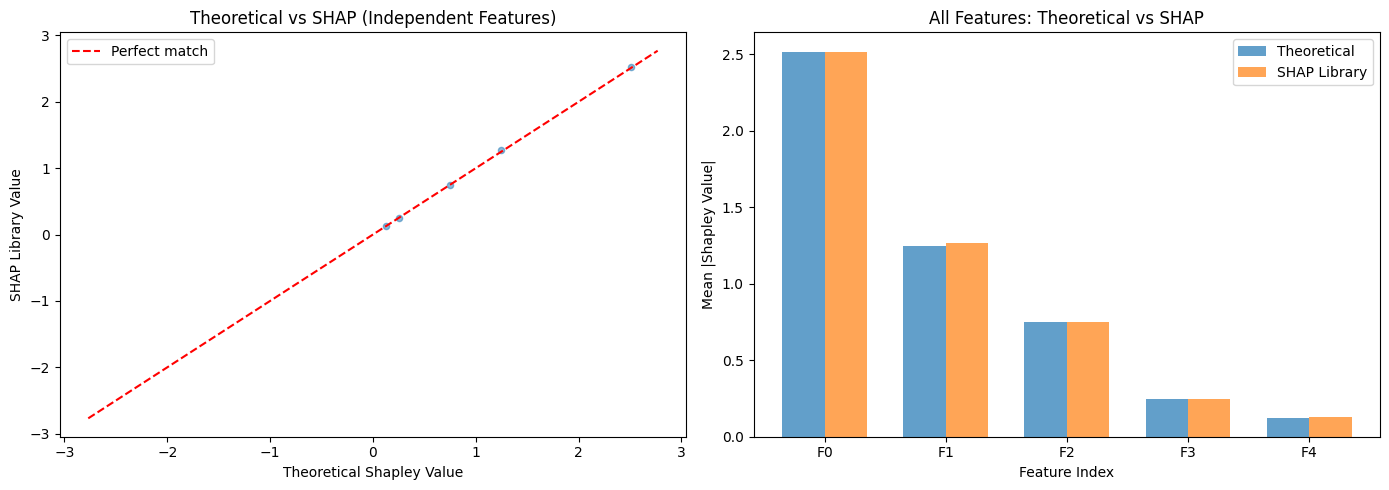


Correlation between theoretical and SHAP values: 1.0000
With independent features, SHAP values closely match the ground truth!


In [49]:
# Compare: theoretical vs SHAP library
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: theoretical vs SHAP
axes[0].scatter(theoretical_shapley, shap_vals, alpha=0.5, s=20)
max_val = max(np.abs(theoretical_shapley).max(), np.abs(shap_vals).max()) * 1.1
axes[0].plot([-max_val, max_val], [-max_val, max_val], 'r--', label='Perfect match')
axes[0].set_xlabel('Theoretical Shapley Value')
axes[0].set_ylabel('SHAP Library Value')
axes[0].set_title('Theoretical vs SHAP (Independent Features)')
axes[0].legend()

# Bar chart: all features
x_pos = np.arange(n_features)
width = 0.35

axes[1].bar(x_pos - width/2, theoretical_shapley, width, label='Theoretical', alpha=0.7)
axes[1].bar(x_pos + width/2, shap_vals, width, label='SHAP Library', alpha=0.7)
axes[1].set_xlabel('Feature Index')
axes[1].set_ylabel('Mean |Shapley Value|')
axes[1].set_title('All Features: Theoretical vs SHAP')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f'F{i}' for i in range(n_features)])
axes[1].legend()

plt.tight_layout()
plt.show()

correlation = np.corrcoef(theoretical_shapley, shap_vals)[0, 1]
print(f"\nCorrelation between theoretical and SHAP values: {correlation:.4f}")
print("With independent features, SHAP values closely match the ground truth!")

---
## Part 2: Breaking Shapley Values — Duplicated Features

We create **100 duplicates of Feature 0** in two variants:

1. **Noisy duplicates** (`X_dup`): 50 with low noise (corr ≈ 0.999) + 50 with high noise (corr ≈ 0.7)
2. **Perfect duplicates** (`X_dup_perfect`): exact copies (corr = 1.0)

In the real world, this mirrors a common pattern:
- Creating rolling averages, lags, and transformations of the same underlying signal
- One-hot encoding of similar categorical features
- Multiple lab tests measuring the same biological process

The key finding: **the dilution effect depends on the model type**:
- **Linear Regression**: unaffected by noisy duplicates (OLS finds the clean signal), but diluted by perfect duplicates (collinearity spreads weights equally)
- **LGBM**: unaffected by perfect duplicates (deterministic tie-breaking picks F0), but diluted by noisy duplicates (different trees split on different copies)

In [50]:
# Duplicate Feature 0 (the most important one) 100 times — with noise
n_duplicates = 100
n_low_noise = 50
n_high_noise = 50
low_noise_std = 0.01
high_noise_std = 0.3

# First 50: Feature 0 + small noise (highly correlated)
low_noise_dups = X[:, 0:1] + np.random.normal(0, low_noise_std, size=(n_samples, n_low_noise))

# Last 50: Feature 0 + high noise (weakly correlated)
high_noise_dups = X[:, 0:1] + np.random.normal(0, high_noise_std, size=(n_samples, n_high_noise))

X_dup = np.hstack([X, low_noise_dups, high_noise_dups])

# Target stays the same — duplicates don't contribute to y
y_dup = y.copy()

print(f"Extended data shape: {X_dup.shape}")
print("Features 0-4:    original features")
print(f"Features 5-54:   Feature 0 + low noise  (std={low_noise_std})")
print(f"Features 55-104: Feature 0 + high noise (std={high_noise_std})")

# Show correlations
corr_low  = np.corrcoef(X_dup[:, 0], X_dup[:, 5])[0, 1]
corr_high = np.corrcoef(X_dup[:, 0], X_dup[:, 55])[0, 1]
print("\nCorrelation with Feature 0:")
print(f"  Low-noise duplicate  (F5):  {corr_low:.4f}")
print(f"  High-noise duplicate (F55): {corr_high:.4f}")

Extended data shape: (10000, 105)
Features 0-4:    original features
Features 5-54:   Feature 0 + low noise  (std=0.01)
Features 55-104: Feature 0 + high noise (std=0.3)

Correlation with Feature 0:
  Low-noise duplicate  (F5):  0.9994
  High-noise duplicate (F55): 0.6915


In [51]:
# Perfect duplication of Feature 0 (no noise)
X_dup_perfect = np.hstack([X, np.tile(X[:, 0:1], (1, n_duplicates))])
y_dup_perfect = y.copy()

print(f"Perfect duplication shape: {X_dup_perfect.shape}")
print(f"Correlation F0 vs F5: {np.corrcoef(X_dup_perfect[:, 0], X_dup_perfect[:, 5])[0, 1]:.4f}")

Perfect duplication shape: (10000, 105)
Correlation F0 vs F5: 1.0000


In [52]:
# Linear Regression - Train model on the extended dataset - X_dup
model_dup = LinearRegression(fit_intercept=True)
model_dup.fit(X_dup, y_dup)

# Calculate theoretical Shapley values for all datapoints and get the mean on duplicated dataset
from tqdm import tqdm

theoretical_shapley_dup = []
feature_means_dup = X_dup.mean(axis=0)
for x in tqdm(X_dup):
    theoretical_shapley_row_dup = get_shapley_values_linear_independent(
        model_dup.coef_, x, feature_means_dup
    )
    theoretical_shapley_dup.append(np.abs(theoretical_shapley_row_dup))

theoretical_shapley_dup = np.array(theoretical_shapley_dup)
theoretical_shapley_dup = theoretical_shapley_dup.mean(axis=0)

# print("Linear Regression - On Syntethic data where features 5-54 given small noise and 55-104 given high noise of feature 0")
# print("Learned weights (selected features):")
# print(f"  Feature 0 (original dominant):  {model_dup.coef_[0]:.4f} (true: 10.0)")
# print(f"  Feature 1:                      {model_dup.coef_[1]:.4f} (true: 5.0)")
# print(f"  Feature 5 (1st duplicate):      {model_dup.coef_[5]:.4f} (true: 0.0)")
# print(f"  Feature 50 (45th duplicate):    {model_dup.coef_[50]:.4f} (true: 0.0)")
# print(f"\nNote: LinearRegression splits weight across duplicates.")
# print(f"Sum of weights for Feature 0 + all duplicates: {model_dup.coef_[0] + model_dup.coef_[5:].sum():.4f}")
# print(f"R² score: {model_dup.score(X_dup, y_dup):.6f}")

print("\nTheoretical SHAP On Syntethic data where features 5-54 given small noise and 55-104 given high noise of feature 0:")
print(f"  Feature 0 (original):   {theoretical_shapley_dup[0]:.4f}")
print(f"  Feature 1:              {theoretical_shapley_dup[1]:.4f}")
print(f"  Feature 5 (dup):        {theoretical_shapley_dup[5]:.4f}")
print(f"  Feature 50 (dup):       {theoretical_shapley_dup[50]:.4f}")
print(f"\nSum of SHAP for Feature 0 + all duplicates: {theoretical_shapley_dup[0] + theoretical_shapley_dup[5:].sum():.4f}")
print(f"Original Feature 0 SHAP (without duplicates): {theoretical_shapley[0]:.4f}")

100%|██████████| 10000/10000 [00:00<00:00, 338580.71it/s]


Theoretical SHAP On Syntethic data where features 5-54 given small noise and 55-104 given high noise of feature 0:
  Feature 0 (original):   2.5131
  Feature 1:              1.2469
  Feature 5 (dup):        0.0000
  Feature 50 (dup):       0.0000

Sum of SHAP for Feature 0 + all duplicates: 2.5131
Original Feature 0 SHAP (without duplicates): 2.5131


In [53]:
# Linear Regression - Train model on the extended dataset - X_dup_perfect
model_dup = LinearRegression(fit_intercept=True)
model_dup.fit(X_dup_perfect, y_dup_perfect)

# Calculate theoretical Shapley values for all datapoints and get the mean on duplicated dataset
from tqdm import tqdm

theoretical_shapley_dup = []
feature_means_dup = X_dup_perfect.mean(axis=0)
for x in tqdm(X_dup_perfect):
    theoretical_shapley_row_dup = get_shapley_values_linear_independent(
        model_dup.coef_, x, feature_means_dup
    )
    theoretical_shapley_dup.append(np.abs(theoretical_shapley_row_dup))

theoretical_shapley_dup = np.array(theoretical_shapley_dup)
theoretical_shapley_dup = theoretical_shapley_dup.mean(axis=0)

# print("Linear Regression - On Syntethic data where features 5-104 is perfect duplicates of feature 0")
# print("Learned weights (selected features):")
# print(f"  Feature 0 (original dominant):  {model_dup.coef_[0]:.4f} (true: 10.0)")
# print(f"  Feature 1:                      {model_dup.coef_[1]:.4f} (true: 5.0)")
# print(f"  Feature 5 (1st duplicate):      {model_dup.coef_[5]:.4f} (true: 0.0)")
# print(f"  Feature 50 (45th duplicate):    {model_dup.coef_[50]:.4f} (true: 0.0)")
# print(f"\nNote: LinearRegression splits weight across duplicates.")
# print(f"Sum of weights for Feature 0 + all duplicates: {model_dup.coef_[0] + model_dup.coef_[5:].sum():.4f}")
# print(f"R² score: {model_dup.score(X_dup, y_dup):.6f}")

print("\nTheoretical SHAP values On Syntethic data where features 5-104 is perfect duplicates of feature 0")
print(f"  Feature 0 (original):   {theoretical_shapley_dup[0]:.4f}")
print(f"  Feature 1:              {theoretical_shapley_dup[1]:.4f}")
print(f"  Feature 5 (dup):        {theoretical_shapley_dup[5]:.4f}")
print(f"  Feature 50 (dup):       {theoretical_shapley_dup[50]:.4f}")
print(f"\nSum of SHAP for Feature 0 + all duplicates: {theoretical_shapley_dup[0] + theoretical_shapley_dup[5:].sum():.4f}")
print(f"Original Feature 0 SHAP (without duplicates): {theoretical_shapley[0]:.4f}")

100%|██████████| 10000/10000 [00:00<00:00, 334069.07it/s]


Theoretical SHAP values On Syntethic data where features 5-104 is perfect duplicates of feature 0
  Feature 0 (original):   0.0249
  Feature 1:              1.2469
  Feature 5 (dup):        0.0249
  Feature 50 (dup):       0.0249

Sum of SHAP for Feature 0 + all duplicates: 2.5131
Original Feature 0 SHAP (without duplicates): 2.5131


In [54]:
# Calculate SHAP values on the duplicated dataset
model_dup = LinearRegression(fit_intercept=True)
model_dup.fit(X_dup, y_dup)
background_dup = shap.sample(X_dup, 50)
explainer_dup = shap.KernelExplainer(model_dup.predict, background_dup)
shap_values_dup = explainer_dup.shap_values(shap.sample(X_dup, int(len(X_dup) * 0.1)), nsamples=500)

shap_vals_dup = np.abs(shap_values_dup).mean(axis=0)

print("Linear Regression : SHAP values on Syntethic data where features 5-54 given small noise and 55-104 given high noise of feature 0:")
print(f"  Feature 0 (original):   {shap_vals_dup[0]:.4f}")
print(f"  Feature 1:              {shap_vals_dup[1]:.4f}")
print(f"  Feature 5 (1st dup):    {shap_vals_dup[5]:.4f}")
print(f"  Feature 50 (45th dup):  {shap_vals_dup[50]:.4f}")
print(f"  Feature 100 (95th dup):  {shap_vals_dup[100]:.4f}")
print(f"\nSum of SHAP for Feature 0 + all duplicates: {shap_vals_dup[0] + shap_vals_dup[n_features:].sum():.4f}")
print(f"Original Feature 0 SHAP (without duplicates): {shap_vals[0]:.4f}")

model_dup = lgb.LGBMRegressor(verbose=0)
model_dup.fit(X_dup, y_dup)
explainer = shap.TreeExplainer(model_dup)
shap_values_dup = explainer.shap_values(X_dup)
shap_vals_dup = np.abs(shap_values_dup).mean(axis=0)

print("\nLGBM : SHAP values on Syntethic data where features 5-54 given small noise and 55-104 given high noise of feature 0:")
print(f"  Feature 0 (original):   {shap_vals_dup[0]:.4f}")
print(f"  Feature 1:              {shap_vals_dup[1]:.4f}")
print(f"  Feature 5 (1st dup):    {shap_vals_dup[5]:.4f}")
print(f"  Feature 50 (45th dup):  {shap_vals_dup[50]:.4f}")
print(f"  Feature 100 (95th dup):  {shap_vals_dup[100]:.4f}")
print(f"\nSum of SHAP for Feature 0 + all duplicates: {shap_vals_dup[0] + shap_vals_dup[n_features:].sum():.4f}")
print(f"Original Feature 0 SHAP (without duplicates): {shap_vals[0]:.4f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Linear Regression : SHAP values on Syntethic data where features 5-54 given small noise and 55-104 given high noise of feature 0:
  Feature 0 (original):   2.4901
  Feature 1:              1.2995
  Feature 5 (1st dup):    0.0000
  Feature 50 (45th dup):  0.0000
  Feature 100 (95th dup):  0.0000

Sum of SHAP for Feature 0 + all duplicates: 2.4901
Original Feature 0 SHAP (without duplicates): 2.5167

LGBM : SHAP values on Syntethic data where features 5-54 given small noise and 55-104 given high noise of feature 0:
  Feature 0 (original):   0.0062
  Feature 1:              1.2284
  Feature 5 (1st dup):    0.1574
  Feature 50 (45th dup):  0.0543
  Feature 100 (95th dup):  0.0005

Sum of SHAP for Feature 0 + all duplicates: 3.1214
Original Feature 0 SHAP (without duplicates): 2.5167


In [55]:
# Calculate SHAP values on the duplicated dataset
model_dup = LinearRegression(fit_intercept=True)
model_dup.fit(X_dup_perfect, y_dup_perfect)
background_dup = shap.sample(X_dup_perfect, 50)
explainer_dup = shap.KernelExplainer(model_dup.predict, background_dup)
shap_values_dup = explainer_dup.shap_values(shap.sample(X_dup_perfect, int(len(X_dup_perfect) * 0.1)), nsamples=500)

shap_vals_dup = np.abs(shap_values_dup).mean(axis=0)

print("Linear Regression : SHAP values on Syntethic data where features 5-104 is perfect duplicates of feature 0")
print(f"  Feature 0 (original):   {shap_vals_dup[0]:.4f}")
print(f"  Feature 1:              {shap_vals_dup[1]:.4f}")
print(f"  Feature 5 (1st dup):    {shap_vals_dup[5]:.4f}")
print(f"  Feature 50 (45th dup):  {shap_vals_dup[50]:.4f}")
print(f"  Feature 100 (95th dup):  {shap_vals_dup[100]:.4f}")
print(f"\nSum of SHAP for Feature 0 + all duplicates: {shap_vals_dup[0] + shap_vals_dup[n_features:].sum():.4f}")
print(f"Original Feature 0 SHAP (without duplicates): {shap_vals[0]:.4f}")

model_dup = lgb.LGBMRegressor(verbose=0)
model_dup.fit(X_dup_perfect, y_dup_perfect)
explainer = shap.TreeExplainer(model_dup)
shap_values_dup = explainer.shap_values(X_dup_perfect)
shap_vals_dup = np.abs(shap_values_dup).mean(axis=0)

print("\nLGBM : SHAP values on Syntethic data where features 5-104 is perfect duplicates of feature 0")
print(f"  Feature 0 (original):   {shap_vals_dup[0]:.4f}")
print(f"  Feature 1:              {shap_vals_dup[1]:.4f}")
print(f"  Feature 5 (1st dup):    {shap_vals_dup[5]:.4f}")
print(f"  Feature 50 (45th dup):  {shap_vals_dup[50]:.4f}")
print(f"  Feature 100 (95th dup):  {shap_vals_dup[100]:.4f}")
print(f"\nSum of SHAP for Feature 0 + all duplicates: {shap_vals_dup[0] + shap_vals_dup[n_features:].sum():.4f}")
print(f"Original Feature 0 SHAP (without duplicates): {shap_vals[0]:.4f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Linear Regression : SHAP values on Syntethic data where features 5-104 is perfect duplicates of feature 0
  Feature 0 (original):   0.0190
  Feature 1:              1.1224
  Feature 5 (1st dup):    0.0161
  Feature 50 (45th dup):  0.0172
  Feature 100 (95th dup):  0.0196

Sum of SHAP for Feature 0 + all duplicates: 1.6342
Original Feature 0 SHAP (without duplicates): 2.5167

LGBM : SHAP values on Syntethic data where features 5-104 is perfect duplicates of feature 0
  Feature 0 (original):   2.5164
  Feature 1:              1.2382
  Feature 5 (1st dup):    0.0000
  Feature 50 (45th dup):  0.0000
  Feature 100 (95th dup):  0.0000

Sum of SHAP for Feature 0 + all duplicates: 2.5164
Original Feature 0 SHAP (without duplicates): 2.5167


---
## Part 3: Solution 1 — Direct Group Shapley

The first fix: **group related features** and calculate Shapley values at the group level.

Instead of asking "What is Feature 0's contribution?", we ask "What is the contribution of the *concept* that Feature 0 and its duplicates represent?"

### Two approaches:

**Method A: Sum within groups** (simple but approximate)
- Calculate individual SHAP values as usual
- Sum the SHAP values of features within each group
- Fast but doesn't account for within-group interactions

**Method B: Direct group Shapley** (exact but expensive)
- Treat each group as a single "player" in the Shapley game
- Calculate marginal contributions of entire groups across coalitions
- Computationally: $2^G$ coalitions where $G$ = number of groups (instead of $2^N$)

In [56]:
# =========================================================
# METHOD A: Sum SHAP values within groups (Simple Approach)
# =========================================================

groups = {
    'F0_concept': [0] + list(range(n_features, n_features + n_duplicates)),
    'F1': [1],
    'F2': [2],
    'F3': [3],
    'F4': [4],
}

# Sum SHAP values within each group
group_shap_summed = {}
for group_name, feature_indices in groups.items():
    group_shap_summed[group_name] = sum(shap_vals_dup[idx] for idx in feature_indices)

# Sort by absolute value
sorted_groups = sorted(group_shap_summed.items(), key=lambda x: abs(x[1]), reverse=True)

print("Method A: Summed Group SHAP Values:")
print("-" * 45)
for name, val in sorted_groups:
    print(f"  {name:15s}: {val:+.4f}")

print("\nFeature 0 concept is now correctly identified as the dominant driver!")

Method A: Summed Group SHAP Values:
---------------------------------------------
  F0_concept     : +2.5164
  F1             : +1.2382
  F2             : +0.7366
  F3             : +0.2287
  F4             : +0.1109

Feature 0 concept is now correctly identified as the dominant driver!


In [57]:
# =========================================================
# METHOD B: Direct Group Shapley Calculation (From Scratch)
# =========================================================

def direct_group_shapley(model, X_background, x_instance, group_definitions):
    """
    Calculate Shapley values where each GROUP is treated as a single player.

    Instead of computing contributions for individual features, we compute
    contributions for groups of features. A group either fully participates
    in a coalition (all its features are present) or doesn't participate
    (all its features are replaced by background values).
    """
    group_names = list(group_definitions.keys())
    n_groups = len(group_names)

    def coalition_value(coalition_groups):
        active_features = set()
        for g in coalition_groups:
            active_features.update(group_definitions[g])

        predictions = []
        for bg_sample in X_background:
            x_modified = bg_sample.copy()
            for feat_idx in active_features:
                x_modified[feat_idx] = x_instance[feat_idx]
            predictions.append(model.predict(x_modified.reshape(1, -1))[0])

        return np.mean(predictions)

    shapley_values = {}

    for target_group in group_names:
        other_groups = [g for g in group_names if g != target_group]
        phi = 0.0

        for coalition_size in range(len(other_groups) + 1):
            for coalition in combinations(other_groups, coalition_size):
                coalition = list(coalition)

                v_with = coalition_value(coalition + [target_group])
                v_without = coalition_value(coalition)
                marginal = v_with - v_without

                s = len(coalition)
                weight = (factorial(s) * factorial(n_groups - s - 1)) / factorial(n_groups)

                phi += weight * marginal

        shapley_values[target_group] = phi

    return shapley_values

print("Direct Group Shapley function defined.")
print(f"With {len(groups)} groups, this evaluates {2**len(groups)} coalitions.")

Direct Group Shapley function defined.
With 5 groups, this evaluates 32 coalitions.


In [58]:
# Demo: Direct Group Shapley on the duplicated dataset (5 groups -> 2^5 = 32 coalitions)
bg_dup_small = shap.sample(X_dup, 50)
x_instance = X_dup[0]

print("Calculating Direct Group Shapley values on duplicated dataset...")
print(f"Groups: {len(groups)} -> {2**len(groups)} coalitions")
print("(This treats each group as a single player in the Shapley game)\n")

group_shapley_direct = direct_group_shapley(model_dup, bg_dup_small, x_instance, groups)

sorted_direct = sorted(group_shapley_direct.items(), key=lambda x: abs(x[1]), reverse=True)
print("Direct Group Shapley Values:")
print("-" * 40)
for name, val in sorted_direct:
    print(f"  {name:15s}: {val:+.4f}")

Calculating Direct Group Shapley values on duplicated dataset...
Groups: 5 -> 32 coalitions
(This treats each group as a single player in the Shapley game)

Direct Group Shapley Values:
----------------------------------------
  F1             : +1.9760
  F0_concept     : -1.4811
  F2             : +0.6613
  F4             : -0.1670
  F3             : +0.1219


In [59]:
# Demo: Direct Group Shapley on the duplicated dataset (5 groups -> 2^5 = 32 coalitions)
# But not only using 1 instance, calculate for 10% of the X dup
group_shapley_direct = {k:[] for k, v in sorted_direct}
background_dup_group = shap.sample(X_dup, 50)

for x_instance in tqdm(shap.sample(X_dup, int(len(X_dup) * 0.01))) :
    group_shapley_direct_row = direct_group_shapley(model_dup, background_dup_group, x_instance, groups)
    sorted_direct_row = sorted(group_shapley_direct_row.items(), key=lambda x: abs(x[1]), reverse=True)

    for k, v in sorted_direct_row:
        group_shapley_direct[k].append(v)

group_shapley_direct = {k:np.mean(np.abs(v)) for k, v in group_shapley_direct.items()}
sorted_direct = sorted(group_shapley_direct.items(), key=lambda x: abs(x[1]), reverse=True)
print("Direct Group Shapley Values:")
print("-" * 40)
for name, val in sorted_direct:
    print(f"  {name:15s}: {val:+.4f}")

100%|██████████| 100/100 [03:13<00:00,  1.94s/it]

Direct Group Shapley Values:
----------------------------------------
  F0_concept     : +2.6741
  F1             : +1.1409
  F2             : +0.7247
  F3             : +0.2312
  F4             : +0.1135


In [60]:
# Compare: Individual SHAP vs Summed Group vs Direct Group
# (on the duplicated dataset)

model_dup = LinearRegression(fit_intercept=True)
model_dup.fit(X_dup, y_dup)

# Individual SHAP for a single instance
bg_for_shap = shap.sample(X_dup, 50)
explainer_single = shap.KernelExplainer(model_dup.predict, bg_for_shap)
shap_vals_single = explainer_single.shap_values(X_dup[0:1], nsamples=300)
sv_single = shap_vals_single[0] if isinstance(shap_vals_single, list) else shap_vals_single.flatten()


# Comparison
print(f"{'Method':<25} {'F0_concept':>12} {'F1':>8} {'F2':>8} {'F3':>8} {'F4':>8}")
print("-" * 70)

# Individual: show feature 0 only (not the group)
print(f"{'Individual (F0 only)':<25} {sv_single[0]:>12.4f} {sv_single[1]:>8.4f} {sv_single[2]:>8.4f} {sv_single[3]:>8.4f} {sv_single[4]:>8.4f}")
print(f"{'Summed Group':<25} {group_shap_summed['F0_concept']:>12.4f} {group_shap_summed['F1']:>8.4f} {group_shap_summed['F2']:>8.4f} {group_shap_summed['F3']:>8.4f} {group_shap_summed['F4']:>8.4f}")
print(f"{'Direct Group Shapley':<25} {group_shapley_direct['F0_concept']:>12.4f} {group_shapley_direct['F1']:>8.4f} {group_shapley_direct['F2']:>8.4f} {group_shapley_direct['F3']:>8.4f} {group_shapley_direct['F4']:>8.4f}")

print("\nNotice: Individual SHAP for F0 alone is small (diluted across duplicates).")
print("Both grouping methods correctly recover F0_concept as the dominant driver.")

  0%|          | 0/1 [00:00<?, ?it/s]

Method                      F0_concept       F1       F2       F3       F4
----------------------------------------------------------------------
Individual (F0 only)           -1.4360   1.9647   0.6824   0.1125  -0.2072
Summed Group                    2.5164   1.2382   0.7366   0.2287   0.1109
Direct Group Shapley            2.6741   1.1409   0.7247   0.2312   0.1135

Notice: Individual SHAP for F0 alone is small (diluted across duplicates).
Both grouping methods correctly recover F0_concept as the dominant driver.


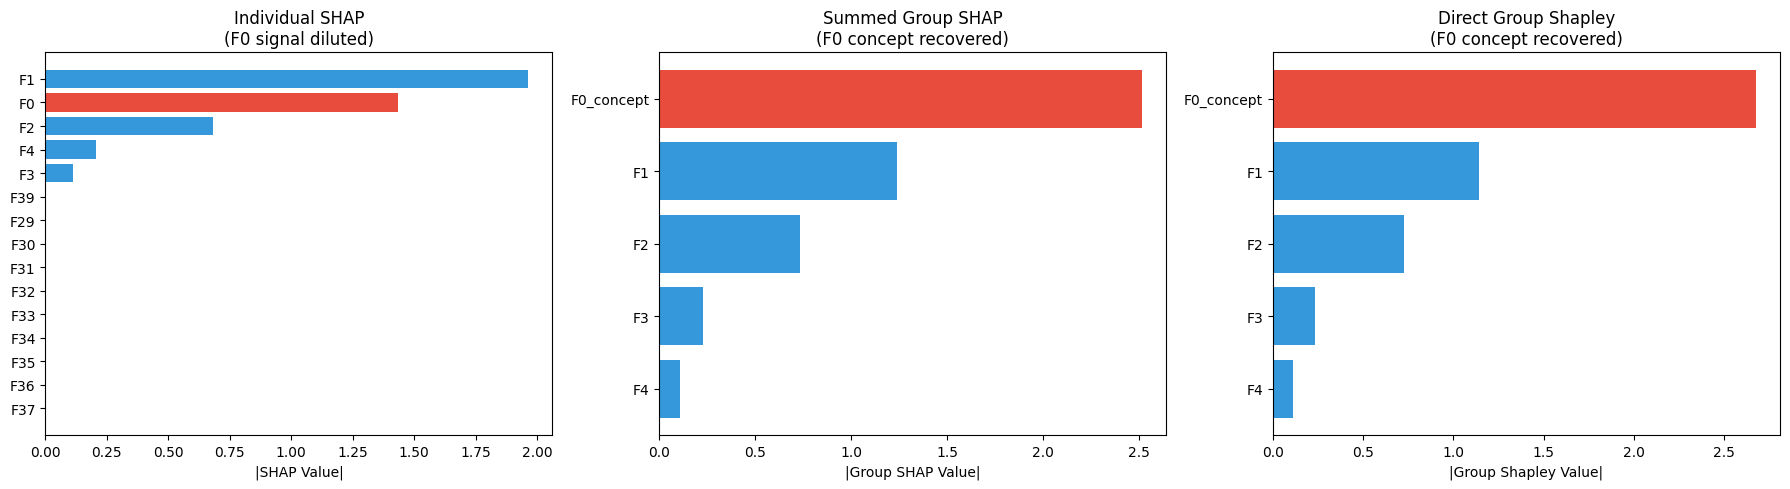

In [61]:
# Visualization of the three methods
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Individual SHAP — show top features
n_show_ind = min(len(sv_single), 15)
top_ind = np.argsort(np.abs(sv_single))[::-1][:n_show_ind]
colors = ['#e74c3c' if i == 0 else '#e67e22' if i >= n_features else '#3498db' for i in top_ind]
axes[0].barh(range(n_show_ind), np.abs(sv_single[top_ind]), color=colors)
axes[0].set_yticks(range(n_show_ind))
axes[0].set_yticklabels([f'F{i}' for i in top_ind])
axes[0].set_title('Individual SHAP\n(F0 signal diluted)')
axes[0].set_xlabel('|SHAP Value|')
axes[0].invert_yaxis()

# Summed Group
sg_sorted = sorted(group_shap_summed.items(), key=lambda x: abs(x[1]), reverse=True)
sg_names = [x[0] for x in sg_sorted]
sg_vals = [abs(x[1]) for x in sg_sorted]
sg_colors = ['#e74c3c' if 'F0' in n else '#3498db' for n in sg_names]
axes[1].barh(range(len(sg_names)), sg_vals, color=sg_colors)
axes[1].set_yticks(range(len(sg_names)))
axes[1].set_yticklabels(sg_names)
axes[1].set_title('Summed Group SHAP\n(F0 concept recovered)')
axes[1].set_xlabel('|Group SHAP Value|')
axes[1].invert_yaxis()

# Direct Group Shapley
dg_sorted = sorted(group_shapley_direct.items(), key=lambda x: abs(x[1]), reverse=True)
dg_names = [x[0] for x in dg_sorted]
dg_vals = [abs(x[1]) for x in dg_sorted]
dg_colors = ['#e74c3c' if 'F0' in n else '#3498db' for n in dg_names]
axes[2].barh(range(len(dg_names)), dg_vals, color=dg_colors)
axes[2].set_yticks(range(len(dg_names)))
axes[2].set_yticklabels(dg_names)
axes[2].set_title('Direct Group Shapley\n(F0 concept recovered)')
axes[2].set_xlabel('|Group Shapley Value|')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

### Key Takeaway from Part 3

Both grouping methods **recover the true signal**:
- **Summed Group SHAP** is simpler and faster — just sum the individual SHAP values within each group
- **Direct Group Shapley** is more principled — it directly computes the group's marginal contribution

In practice, they often give similar results. Direct Group Shapley is more accurate when there are complex within-group interactions, but it's computationally expensive ($O(2^G)$ where $G$ is the number of groups).

---
## Part 4: Solution 2 — Greedy Iterative ("Winner Takes It All")

Instead of predefining groups, the **Greedy Iterative** method discovers redundancy automatically:

1. **Select the Winner**: find the feature with the highest mean |SHAP|
2. **Condition**: lock it in, and also condition all features with |correlation| > threshold (so correlated features drop to ~0)
3. **Repeat**: recalculate SHAP on remaining features and pick the next winner

This gives a ranked, non-redundant list of drivers — no domain knowledge required.

We test across 4 combinations: **LinearRegression vs LGBM** × **Noisy vs Perfect duplicates**.

In [62]:
from greedy_iterative import greedy_iterative_shapley

print("Greedy Iterative Shapley function imported from greedy_iterative.py")

Greedy Iterative Shapley function imported from greedy_iterative.py


In [63]:
# =========================================================
# Greedy Iterative: 4 combinations (2 models x 2 datasets)
# =========================================================
import lightgbm as lgb

feature_names_dup = [f'F{i}' if i < n_features else f'F0_dup{i-n_features+1}' for i in range(n_features + n_duplicates)]

# Train models on both datasets
model_lr_noisy   = LinearRegression().fit(X_dup, y_dup)
model_lr_perfect = LinearRegression().fit(X_dup_perfect, y_dup_perfect)
model_lgb_noisy  = lgb.LGBMRegressor(verbose=-1, n_estimators=100).fit(X_dup, y_dup)
model_lgb_perfect = lgb.LGBMRegressor(verbose=-1, n_estimators=100).fit(X_dup_perfect, y_dup_perfect)

# Sampling
sample_pct = 0.01
bg_noisy   = shap.sample(X_dup, 50)
bg_perfect = shap.sample(X_dup_perfect, 50)
X_exp_noisy   = shap.sample(X_dup, int(len(X_dup) * sample_pct))
X_exp_perfect = shap.sample(X_dup_perfect, int(len(X_dup_perfect) * sample_pct))

configs = [
    ("LinearReg + Noisy Dup",   model_lr_noisy,    bg_noisy,   X_exp_noisy),
    ("LinearReg + Perfect Dup", model_lr_perfect,   bg_perfect, X_exp_perfect),
    ("LGBM + Noisy Dup",        model_lgb_noisy,   bg_noisy,   X_exp_noisy),
    ("LGBM + Perfect Dup",      model_lgb_perfect,  bg_perfect, X_exp_perfect),
]

all_results = {}
for name, model, bg, X_exp in configs:
    print(f"\n{'='*60}")
    print(f"  {name}")
    print(f"{'='*60}")
    results = greedy_iterative_shapley(
        model, bg, X_exp,
        feature_names=feature_names_dup,
        n_steps=8,
        threshold=0.01,
        nsamples=200,
        corr_threshold=0.8
    )
    all_results[name] = results


  LinearReg + Noisy Dup
  (Correlation conditioning threshold: 0.8)


  0%|          | 0/100 [00:00<?, ?it/s]

  Step 1: Selected         F0 | mean |SHAP| = 2.6737 (+ 50 correlated)


  0%|          | 0/100 [00:00<?, ?it/s]

  Step 2: Selected         F1 | mean |SHAP| = 1.1387


  0%|          | 0/100 [00:00<?, ?it/s]

  Step 3: Selected         F2 | mean |SHAP| = 0.7323


  0%|          | 0/100 [00:00<?, ?it/s]

  Step 4: Selected         F3 | mean |SHAP| = 0.2494


  0%|          | 0/100 [00:00<?, ?it/s]

  Step 5: Selected         F4 | mean |SHAP| = 0.1251


  0%|          | 0/100 [00:00<?, ?it/s]

  Step 6: Stopping — max mean |SHAP| = 0.0000 < threshold 0.01

  LinearReg + Perfect Dup
  (Correlation conditioning threshold: 0.8)


  0%|          | 0/100 [00:00<?, ?it/s]

  Step 1: Selected         F1 | mean |SHAP| = 0.8809


  0%|          | 0/100 [00:00<?, ?it/s]

  Step 2: Selected         F2 | mean |SHAP| = 0.5044


  0%|          | 0/100 [00:00<?, ?it/s]

  Step 3: Selected         F3 | mean |SHAP| = 0.1599


  0%|          | 0/100 [00:00<?, ?it/s]

  Step 4: Selected         F4 | mean |SHAP| = 0.0935


  0%|          | 0/100 [00:00<?, ?it/s]

  Step 5: Selected   F0_dup72 | mean |SHAP| = 0.0418 (+ 100 correlated)

  LGBM + Noisy Dup
  (Using TreeExplainer — interventional mode for LGBMRegressor)
  (Correlation conditioning threshold: 0.8)
  Step 1: Selected         F1 | mean |SHAP| = 1.1386
  Step 2: Selected         F2 | mean |SHAP| = 0.7041
  Step 3: Selected   F0_dup41 | mean |SHAP| = 0.3127 (+ 50 correlated)
  Step 4: Selected         F3 | mean |SHAP| = 0.2297
  Step 5: Selected         F4 | mean |SHAP| = 0.1215
  Step 6: Stopping — max mean |SHAP| = 0.0023 < threshold 0.01

  LGBM + Perfect Dup
  (Using TreeExplainer — interventional mode for LGBMRegressor)
  (Correlation conditioning threshold: 0.8)
  Step 1: Selected         F0 | mean |SHAP| = 2.6741 (+ 100 correlated)
  Step 2: Selected         F1 | mean |SHAP| = 1.1465
  Step 3: Selected         F2 | mean |SHAP| = 0.7269
  Step 4: Selected         F3 | mean |SHAP| = 0.2357
  Step 5: Selected         F4 | mean |SHAP| = 0.1192


In [64]:
# Summary comparison table
print(f"{'Config':<28} {'Step 1 (Winner)':<18} {'Step 2':<18} {'Step 3':<18}")
print("-" * 84)
for name, results in all_results.items():
    cols = []
    for r in results[:3]:
        cols.append(f"{r['name']:<10s} {r['mean_abs_shap']:.3f}")
    while len(cols) < 3:
        cols.append("—")
    print(f"{name:<28} {cols[0]:<18} {cols[1]:<18} {cols[2]:<18}")

print('\nFinal List Feature :')
for name, results in all_results.items():
    print(f"{name} : {[i['name'] for i in results]}")

print("\n\nExpected behavior:")
print("  LinearReg + Noisy:   F0 wins step 1, duplicates drop (OLS concentrates weight on clean signal)")
print("  LinearReg + Perfect: Diluted — OLS spreads weight, greedy picks duplicates too")
print("  LGBM + Noisy:        Diluted — different trees split on different noisy copies")
print("  LGBM + Perfect:      F0 wins step 1, duplicates drop (deterministic tie-breaking)")

Config                       Step 1 (Winner)    Step 2             Step 3            
------------------------------------------------------------------------------------
LinearReg + Noisy Dup        F0         2.674   F1         1.139   F2         0.732  
LinearReg + Perfect Dup      F1         0.881   F2         0.504   F3         0.160  
LGBM + Noisy Dup             F1         1.139   F2         0.704   F0_dup41   0.313  
LGBM + Perfect Dup           F0         2.674   F1         1.147   F2         0.727  

Final List Feature :
LinearReg + Noisy Dup : ['F0', 'F1', 'F2', 'F3', 'F4']
LinearReg + Perfect Dup : ['F1', 'F2', 'F3', 'F4', 'F0_dup72']
LGBM + Noisy Dup : ['F1', 'F2', 'F0_dup41', 'F3', 'F4']
LGBM + Perfect Dup : ['F0', 'F1', 'F2', 'F3', 'F4']


Expected behavior:
  LinearReg + Noisy:   F0 wins step 1, duplicates drop (OLS concentrates weight on clean signal)
  LinearReg + Perfect: Diluted — OLS spreads weight, greedy picks duplicates too
  LGBM + Noisy:        Diluted — diffe

### Key Takeaway from Part 4

The Greedy Iterative approach **doesn't require predefined groups** — but its effectiveness depends on the model + data combination:

| Scenario | Step 1 Winner | Does it work? |
|----------|---------------|---------------|
| LinearReg + Noisy Dup | F0 (+50 conditioned) | Yes — OLS concentrates weight on the clean signal |
| LinearReg + Perfect Dup | F1 (F0 diluted to last) | No — OLS spreads weight, F0 group has tiny per-feature SHAP |
| LGBM + Noisy Dup | F1 (F0 group picked 3rd) | Partially — LGBM spreads splits across noisy copies |
| LGBM + Perfect Dup | F0 (+100 conditioned) | Yes — deterministic tie-breaking always picks F0 |

**Correlation-based conditioning** (`corr_threshold=0.8`) is critical: when a winner is selected, all features with |corr| > threshold are automatically conditioned out. Without this, linear models would pick duplicates one by one (features are additive — conditioning one has zero effect on others).

In [65]:
# Summary comparison table
print(f"{'Config':<28} {'Step 1 (Winner)':<25} {'Step 2':<25} {'Step 3':<25}")
print("-" * 105)
for name, results in all_results.items():
    cols = []
    for r in results[:3]:
        cond = f" (+{r['n_conditioned']-1})" if r['n_conditioned'] > 1 else ""
        cols.append(f"{r['name']:<10s} {r['mean_abs_shap']:.3f}{cond}")
    while len(cols) < 3:
        cols.append("—")
    print(f"{name:<28} {cols[0]:<25} {cols[1]:<25} {cols[2]:<25}")

print("\n\nWith corr_threshold=0.8, selecting one F0/F0_dup now also conditions")
print("all correlated duplicates — 'Winner Takes It All' for the entire group.")
print("\nExpected: Step 1 selects F0 (or a dup) + conditions ~100 correlated features.")
print("Step 2 onward should pick genuinely different features (F1, F2, etc.).")

Config                       Step 1 (Winner)           Step 2                    Step 3                   
---------------------------------------------------------------------------------------------------------
LinearReg + Noisy Dup        F0         2.674 (+50)    F1         1.139          F2         0.732         
LinearReg + Perfect Dup      F1         0.881          F2         0.504          F3         0.160         
LGBM + Noisy Dup             F1         1.139          F2         0.704          F0_dup41   0.313 (+50)   
LGBM + Perfect Dup           F0         2.674 (+100)   F1         1.147          F2         0.727         


With corr_threshold=0.8, selecting one F0/F0_dup now also conditions
all correlated duplicates — 'Winner Takes It All' for the entire group.

Expected: Step 1 selects F0 (or a dup) + conditions ~100 correlated features.
Step 2 onward should pick genuinely different features (F1, F2, etc.).


In [66]:
class GroupedShapley:
    """
    Grouped Shapley Value Calculator

    Implements methods from "When Shapley Values Break" (Alon Lanyado, 2026)
    for robust model explainability when features are correlated or duplicated.

    Note: The original article references the medpython package from Medial EarlySign.
    This is a standalone reimplementation of the core concepts.

    Methods:
    --------
    sum_group_shap:       Sum individual SHAP values within predefined groups
    direct_group_shapley: Calculate Shapley values treating groups as single players
    greedy_iterative:     Winner-takes-all iterative feature selection
    """

    def __init__(self, model, X_background, nsamples=200):
        """
        Parameters:
        -----------
        model : fitted model with .predict() method
        X_background : numpy array, background data for SHAP marginalization
        nsamples : int, number of samples for KernelExplainer
        """
        self.model = model
        self.X_background = X_background
        self.nsamples = nsamples

    def _get_individual_shap(self, x_instance):
        """Calculate individual feature SHAP values."""
        explainer = shap.KernelExplainer(self.model.predict, self.X_background)
        sv = explainer.shap_values(x_instance.reshape(1, -1), nsamples=self.nsamples)
        return sv[0] if isinstance(sv, list) else sv.flatten()

    def sum_group_shap(self, x_instance, group_definitions):
        """
        Method A: Sum individual SHAP values within each group.

        Fast and simple. Works well when within-group interactions are minimal.

        Parameters:
        -----------
        x_instance : 1D array, the instance to explain
        group_definitions : dict, group_name -> list of feature indices

        Returns:
        --------
        dict : group_name -> summed SHAP value
        """
        individual_shap = self._get_individual_shap(x_instance)

        result = {}
        for group_name, indices in group_definitions.items():
            result[group_name] = sum(individual_shap[i] for i in indices)

        return result

    def direct_group_shapley(self, x_instance, group_definitions):
        """
        Method B: Direct group-level Shapley calculation.

        Each group is a single player in the coalition game.
        More accurate but O(2^G) where G = number of groups.

        Parameters:
        -----------
        x_instance : 1D array
        group_definitions : dict, group_name -> list of feature indices

        Returns:
        --------
        dict : group_name -> Shapley value
        """
        group_names = list(group_definitions.keys())
        n_groups = len(group_names)

        def coalition_value(coalition_groups):
            active_features = set()
            for g in coalition_groups:
                active_features.update(group_definitions[g])

            predictions = []
            for bg_sample in self.X_background:
                x_mod = bg_sample.copy()
                for idx in active_features:
                    x_mod[idx] = x_instance[idx]
                predictions.append(self.model.predict(x_mod.reshape(1, -1))[0])
            return np.mean(predictions)

        shapley_values = {}
        for target_group in group_names:
            other_groups = [g for g in group_names if g != target_group]
            phi = 0.0

            for s in range(len(other_groups) + 1):
                for coalition in combinations(other_groups, s):
                    coalition = list(coalition)
                    v_with = coalition_value(coalition + [target_group])
                    v_without = coalition_value(coalition)
                    weight = (factorial(s) * factorial(n_groups - s - 1)) / factorial(n_groups)
                    phi += weight * (v_with - v_without)

            shapley_values[target_group] = phi

        return shapley_values

    def greedy_iterative(self, x_instance, feature_names=None, group_definitions=None,
                         n_steps=10, threshold=0.01):
        """
        Greedy Iterative Selection — "Winner Takes It All"

        Iteratively selects the most important feature/group, conditions on it,
        and recalculates remaining contributions. Redundant features automatically
        drop to ~0 after their "representative" is selected.

        Parameters:
        -----------
        x_instance : 1D array
        feature_names : list of str (optional)
        group_definitions : dict (optional) — if provided, works at group level
        n_steps : max iterations
        threshold : stop if max |SHAP| < threshold

        Returns:
        --------
        list of dicts with keys: step, name, shap_value, feature_indices
        """
        n_features = len(x_instance)

        if group_definitions is not None:
            # Group-level greedy
            return self._greedy_groups(x_instance, group_definitions, n_steps, threshold)

        # Feature-level greedy
        if feature_names is None:
            feature_names = [f'F{i}' for i in range(n_features)]

        current_bg = self.X_background.copy()
        remaining = list(range(n_features))
        results = []

        for step in range(n_steps):
            if not remaining:
                break

            explainer = shap.KernelExplainer(self.model.predict, current_bg)
            sv = explainer.shap_values(x_instance.reshape(1, -1), nsamples=self.nsamples)
            sv = sv[0] if isinstance(sv, list) else sv.flatten()

            best_idx = max(remaining, key=lambda i: abs(sv[i]))

            if abs(sv[best_idx]) < threshold:
                break

            results.append({
                'step': step + 1,
                'name': feature_names[best_idx],
                'shap_value': sv[best_idx],
                'feature_indices': [best_idx]
            })

            remaining.remove(best_idx)
            current_bg[:, best_idx] = x_instance[best_idx]

        return results

    def _greedy_groups(self, x_instance, group_definitions, n_steps, threshold):
        """Greedy iterative at the group level."""
        current_bg = self.X_background.copy()
        remaining_groups = dict(group_definitions)
        results = []

        for step in range(n_steps):
            if not remaining_groups:
                break

            # Calculate group SHAP by summing individual SHAP within groups
            explainer = shap.KernelExplainer(self.model.predict, current_bg)
            sv = explainer.shap_values(x_instance.reshape(1, -1), nsamples=self.nsamples)
            sv = sv[0] if isinstance(sv, list) else sv.flatten()

            # Find best group
            group_scores = {}
            for gname, gidx in remaining_groups.items():
                group_scores[gname] = sum(sv[i] for i in gidx)

            best_group = max(group_scores, key=lambda g: abs(group_scores[g]))

            if abs(group_scores[best_group]) < threshold:
                break

            best_indices = remaining_groups[best_group]
            results.append({
                'step': step + 1,
                'name': best_group,
                'shap_value': group_scores[best_group],
                'feature_indices': best_indices
            })

            # Condition on the selected group
            for idx in best_indices:
                current_bg[:, idx] = x_instance[idx]

            del remaining_groups[best_group]

        return results

print("GroupedShapley class defined.")
print("Methods: sum_group_shap(), direct_group_shapley(), greedy_iterative()")

GroupedShapley class defined.
Methods: sum_group_shap(), direct_group_shapley(), greedy_iterative()


---
## Part 5: Application to Healthcare Data — CMS AI Health Outcomes Challenge

### Background

The **CMS Artificial Intelligence Health Outcomes Challenge** was launched by the Centers for Medicare & Medicaid Services (CMS) in 2019 with 300+ entrants (IBM, Merck, Accenture, Deloitte, etc.). The goal: predict adverse health outcomes for Medicare beneficiaries using AI, with a strong emphasis on **explainability**.

**Winner:** [ClosedLoop.ai](https://www.closedloop.ai/cms-challenge/) ($1.6M prize) — they combined SHAP values for XGBoost with attention mechanisms.

**Alon Lanyado** (Medial EarlySign) was also an award winner and applied the Grouped Shapley methods described in this notebook to handle the challenge's hundreds of correlated clinical features.

### Our Approach

Since the actual CMS competition data is restricted, we'll simulate a realistic healthcare prediction scenario:
- Predict **hospital readmission risk** (binary classification)
- Features include demographics, lab values, vitals, and diagnoses
- We'll deliberately include correlated features (as is common in clinical data)
- Then apply our methods to show how standard SHAP misleads and grouped methods fix it

In [67]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [68]:
# =========================================================
# Generate Synthetic CMS-like Healthcare Data
# =========================================================

np.random.seed(42)
n_patients = 2000

# --- Core features (the true drivers) ---
age = np.random.normal(72, 10, n_patients).clip(50, 95)  # Medicare population
hba1c = np.random.normal(6.5, 1.5, n_patients).clip(4, 14)  # Blood sugar control
creatinine = np.random.normal(1.2, 0.5, n_patients).clip(0.3, 5.0)  # Kidney function
systolic_bp = np.random.normal(135, 20, n_patients).clip(90, 200)  # Blood pressure
num_prior_admissions = np.random.poisson(2, n_patients)  # Prior hospital visits
num_medications = np.random.poisson(8, n_patients)  # Polypharmacy

# --- Correlated / derived features (same underlying signal) ---
# These are deliberately correlated with core features to mimic
# the feature engineering common in healthcare ML

# Blood sugar group (correlated with HbA1c)
fasting_glucose = hba1c * 28 + np.random.normal(0, 10, n_patients)  # Derived from HbA1c
avg_glucose_3m = hba1c * 25 + np.random.normal(0, 15, n_patients)   # Another glucose measure
glucose_variability = np.abs(np.random.normal(0, 1, n_patients)) * hba1c * 3  # Glucose SD

# Kidney function group (correlated with creatinine)
bun = creatinine * 12 + np.random.normal(0, 3, n_patients)  # Blood Urea Nitrogen
egfr = 140 - creatinine * 40 + np.random.normal(0, 5, n_patients)  # Estimated GFR
urine_albumin = creatinine * 20 + np.random.normal(0, 8, n_patients)  # Kidney damage marker

# Blood pressure group (correlated with systolic_bp)
diastolic_bp = systolic_bp * 0.6 + np.random.normal(0, 5, n_patients)  # Diastolic
pulse_pressure = systolic_bp - diastolic_bp  # Derived
map_bp = (systolic_bp + 2 * diastolic_bp) / 3  # Mean Arterial Pressure

# Healthcare utilization group (correlated with prior admissions)
er_visits = num_prior_admissions * 0.8 + np.random.poisson(1, n_patients)  # ER visits
outpatient_visits = num_prior_admissions * 2 + np.random.poisson(3, n_patients)
total_cost_prior_year = (num_prior_admissions * 15000 +
                         er_visits * 3000 +
                         np.random.normal(0, 5000, n_patients)).clip(0, None)

# --- Noise features ---
height = np.random.normal(170, 10, n_patients)
weight = np.random.normal(80, 15, n_patients)
bmi = weight / (height/100)**2

# --- Construct DataFrame ---
data = pd.DataFrame({
    # Core features
    'age': age,
    'hba1c': hba1c,
    'creatinine': creatinine,
    'systolic_bp': systolic_bp,
    'num_prior_admissions': num_prior_admissions,
    'num_medications': num_medications,
    # Blood sugar group
    'fasting_glucose': fasting_glucose,
    'avg_glucose_3m': avg_glucose_3m,
    'glucose_variability': glucose_variability,
    # Kidney function group
    'bun': bun,
    'egfr': egfr,
    'urine_albumin': urine_albumin,
    # Blood pressure group
    'diastolic_bp': diastolic_bp,
    'pulse_pressure': pulse_pressure,
    'map_bp': map_bp,
    # Utilization group
    'er_visits': er_visits,
    'outpatient_visits': outpatient_visits,
    'total_cost_prior_year': total_cost_prior_year,
    # Noise
    'height': height,
    'weight': weight,
    'bmi': bmi,
})

# --- Generate target: readmission risk ---
# True relationship: mainly driven by HbA1c, creatinine, prior admissions, and age
logit = (
    0.05 * (age - 72) +
    0.8 * (hba1c - 6.5) +
    1.2 * (creatinine - 1.2) +
    0.02 * (systolic_bp - 135) +
    0.5 * num_prior_admissions +
    0.1 * num_medications +
    np.random.normal(0, 0.5, n_patients)  # noise
    - 2.0  # offset to get ~30% readmission rate
)
prob = 1 / (1 + np.exp(-logit))
y_health = (np.random.uniform(0, 1, n_patients) < prob).astype(int)

print(f"Dataset: {data.shape[0]} patients, {data.shape[1]} features")
print(f"Readmission rate: {y_health.mean():.1%}")
print("\nFeature groups:")
print("  Blood Sugar:  hba1c, fasting_glucose, avg_glucose_3m, glucose_variability")
print("  Kidney:       creatinine, bun, egfr, urine_albumin")
print("  Blood Press:  systolic_bp, diastolic_bp, pulse_pressure, map_bp")
print("  Utilization:  num_prior_admissions, er_visits, outpatient_visits, total_cost_prior_year")
print("  Other:        age, num_medications, height, weight, bmi")

Dataset: 2000 patients, 21 features
Readmission rate: 46.9%

Feature groups:
  Blood Sugar:  hba1c, fasting_glucose, avg_glucose_3m, glucose_variability
  Kidney:       creatinine, bun, egfr, urine_albumin
  Blood Press:  systolic_bp, diastolic_bp, pulse_pressure, map_bp
  Utilization:  num_prior_admissions, er_visits, outpatient_visits, total_cost_prior_year
  Other:        age, num_medications, height, weight, bmi


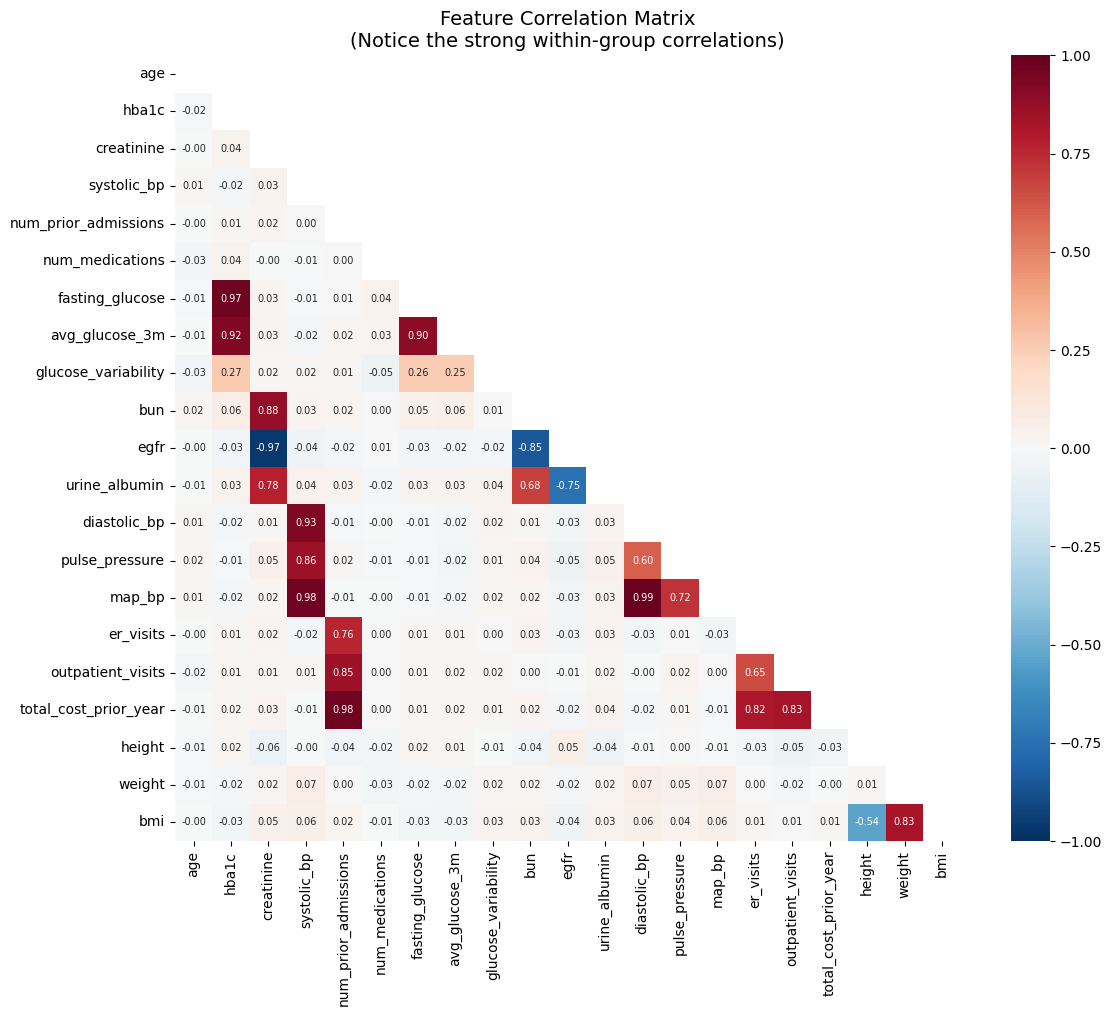


Key correlations:
  hba1c <-> fasting_glucose:       0.971
  creatinine <-> bun:              0.877
  systolic_bp <-> diastolic_bp:    0.926
  num_prior_admissions <-> er_visits: 0.759


In [69]:
# Show correlations within groups
fig, ax = plt.subplots(figsize=(12, 10))
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, ax=ax, square=True,
            annot_kws={'size': 7})
ax.set_title('Feature Correlation Matrix\n(Notice the strong within-group correlations)', fontsize=14)
plt.tight_layout()
plt.show()

print("\nKey correlations:")
print(f"  hba1c <-> fasting_glucose:       {corr.loc['hba1c', 'fasting_glucose']:.3f}")
print(f"  creatinine <-> bun:              {corr.loc['creatinine', 'bun']:.3f}")
print(f"  systolic_bp <-> diastolic_bp:    {corr.loc['systolic_bp', 'diastolic_bp']:.3f}")
print(f"  num_prior_admissions <-> er_visits: {corr.loc['num_prior_admissions', 'er_visits']:.3f}")

In [70]:
# Train LightGBM model
X_health = data.values
feature_names_health = list(data.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X_health, y_health, test_size=0.2, random_state=42, stratify=y_health
)

clf = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    verbose=-1
)

clf.fit(X_train, y_train)

y_pred_proba = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Model AUC-ROC: {auc:.3f}")
print("\nThis model mimics what CMS challenge participants would build:")
print("a gradient-boosted model on clinical features to predict adverse outcomes.")

Model AUC-ROC: 0.772

This model mimics what CMS challenge participants would build:
a gradient-boosted model on clinical features to predict adverse outcomes.


In [71]:
# =========================================================
# Standard SHAP Analysis — The Problem
# =========================================================

# Use TreeExplainer for LightGBM (exact and fast)
explainer_health = shap.TreeExplainer(clf)
shap_values_health = explainer_health.shap_values(X_test)

# For binary classification, TreeExplainer returns [class_0, class_1]
if isinstance(shap_values_health, list):
    shap_values_health = shap_values_health[1]  # Class 1 (readmission)

print("SHAP values calculated for test set.")
print(f"Shape: {np.array(shap_values_health).shape}")

SHAP values calculated for test set.
Shape: (400, 21)


In [72]:
# Global feature importance — standard SHAP
mean_abs_shap = np.abs(shap_values_health).mean(axis=0)
feature_importance = pd.DataFrame({
    'feature': feature_names_health,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

print("Standard SHAP Feature Importance (Global):")
print("=" * 50)
for _, row in feature_importance.iterrows():
    bar = '#' * int(row['mean_abs_shap'] / feature_importance['mean_abs_shap'].max() * 30)
    print(f"  {row['feature']:25s} {row['mean_abs_shap']:.4f}  {bar}")

print("\nPROBLEM: The signal from core features (hba1c, creatinine, etc.)")
print("is diluted across their correlated derivatives!")
print("A clinician would struggle to identify the TRUE drivers.")

Standard SHAP Feature Importance (Global):
  hba1c                     0.5124  ##############################
  creatinine                0.4284  #########################
  fasting_glucose           0.3246  ###################
  age                       0.3140  ##################
  total_cost_prior_year     0.2904  #################
  num_prior_admissions      0.2684  ###############
  avg_glucose_3m            0.2484  ##############
  num_medications           0.2197  ############
  diastolic_bp              0.1785  ##########
  egfr                      0.1668  #########
  weight                    0.1649  #########
  bun                       0.1561  #########
  map_bp                    0.1460  ########
  systolic_bp               0.1374  ########
  pulse_pressure            0.1330  #######
  height                    0.1065  ######
  glucose_variability       0.1063  ######
  urine_albumin             0.1054  ######
  bmi                       0.0916  #####
  outpatient_visits  

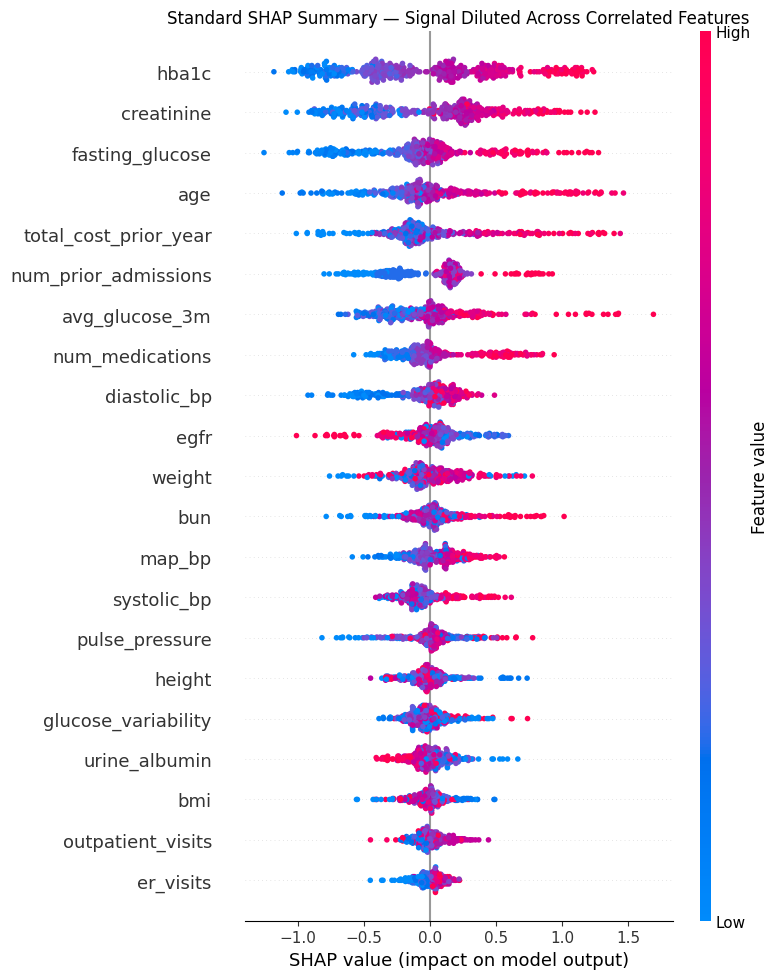

In [73]:
# Standard SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_health, X_test,
                  feature_names=feature_names_health, show=False, max_display=21)
plt.title('Standard SHAP Summary — Signal Diluted Across Correlated Features')
plt.tight_layout()
plt.show()

In [74]:
# =========================================================
# Grouped SHAP — The Solution
# =========================================================

# Define clinically meaningful feature groups
health_groups = {
    'Blood Sugar Control': ['hba1c', 'fasting_glucose', 'avg_glucose_3m', 'glucose_variability'],
    'Kidney Function': ['creatinine', 'bun', 'egfr', 'urine_albumin'],
    'Blood Pressure': ['systolic_bp', 'diastolic_bp', 'pulse_pressure', 'map_bp'],
    'Healthcare Utilization': ['num_prior_admissions', 'er_visits', 'outpatient_visits', 'total_cost_prior_year'],
    'Age': ['age'],
    'Medications': ['num_medications'],
    'Body Composition': ['height', 'weight', 'bmi'],
}

# Convert feature names to indices
health_groups_idx = {}
for group_name, feat_names in health_groups.items():
    health_groups_idx[group_name] = [feature_names_health.index(f) for f in feat_names]

# Method A: Sum individual SHAP values within groups
group_importance = {}
for group_name, indices in health_groups_idx.items():
    group_importance[group_name] = np.abs(shap_values_health[:, indices]).sum(axis=1).mean()

group_imp_df = pd.DataFrame([
    {'group': k, 'mean_abs_shap': v} for k, v in group_importance.items()
]).sort_values('mean_abs_shap', ascending=False)

print("Grouped SHAP Feature Importance (Summed within groups):")
print("=" * 55)
for _, row in group_imp_df.iterrows():
    bar = '#' * int(row['mean_abs_shap'] / group_imp_df['mean_abs_shap'].max() * 30)
    print(f"  {row['group']:25s} {row['mean_abs_shap']:.4f}  {bar}")

print("\nNow the true drivers are clear:")
print("Blood Sugar Control and Kidney Function are the dominant concepts!")

Grouped SHAP Feature Importance (Summed within groups):
  Blood Sugar Control       1.1917  ##############################
  Kidney Function           0.8568  #####################
  Healthcare Utilization    0.7131  #################
  Blood Pressure            0.5949  ##############
  Body Composition          0.3630  #########
  Age                       0.3140  #######
  Medications               0.2197  #####

Now the true drivers are clear:
Blood Sugar Control and Kidney Function are the dominant concepts!


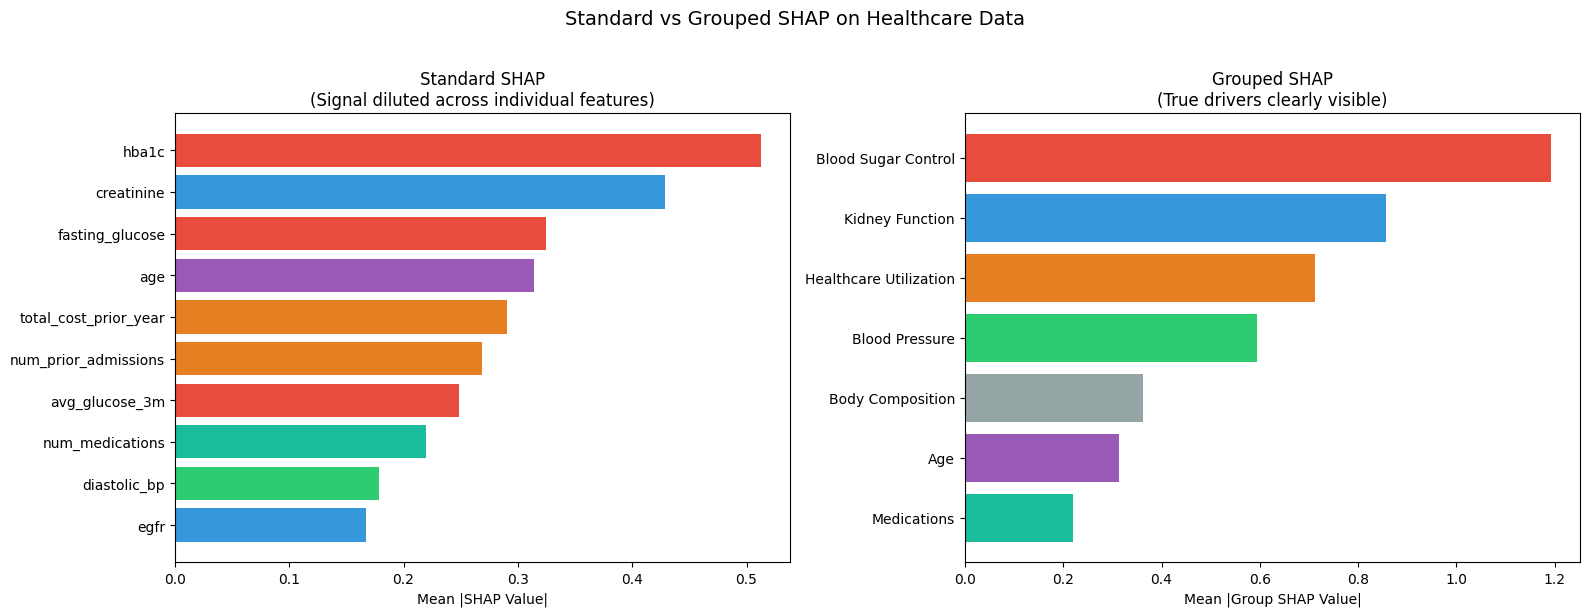

In [75]:
# Visualization: Standard vs Grouped SHAP
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Standard SHAP — top 10 individual features
top_10_health = feature_importance.head(10)
colors_health = []
group_color_map = {
    'Blood Sugar Control': '#e74c3c',
    'Kidney Function': '#3498db',
    'Blood Pressure': '#2ecc71',
    'Healthcare Utilization': '#e67e22',
    'Age': '#9b59b6',
    'Medications': '#1abc9c',
    'Body Composition': '#95a5a6',
}
for feat in top_10_health['feature']:
    for gname, gfeats in health_groups.items():
        if feat in gfeats:
            colors_health.append(group_color_map[gname])
            break

axes[0].barh(range(10), top_10_health['mean_abs_shap'].values, color=colors_health)
axes[0].set_yticks(range(10))
axes[0].set_yticklabels(top_10_health['feature'].values)
axes[0].set_title('Standard SHAP\n(Signal diluted across individual features)')
axes[0].set_xlabel('Mean |SHAP Value|')
axes[0].invert_yaxis()

# Grouped SHAP
group_colors = [group_color_map[g] for g in group_imp_df['group']]
axes[1].barh(range(len(group_imp_df)), group_imp_df['mean_abs_shap'].values, color=group_colors)
axes[1].set_yticks(range(len(group_imp_df)))
axes[1].set_yticklabels(group_imp_df['group'].values)
axes[1].set_title('Grouped SHAP\n(True drivers clearly visible)')
axes[1].set_xlabel('Mean |Group SHAP Value|')
axes[1].invert_yaxis()

plt.suptitle('Standard vs Grouped SHAP on Healthcare Data', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [76]:
# =========================================================
# Greedy Iterative on Healthcare Data (single patient)
# =========================================================

# Pick a high-risk patient
high_risk_idx = np.argmax(y_pred_proba)
x_patient = X_test[high_risk_idx]

print(f"Explaining prediction for patient {high_risk_idx}:")
print(f"  Predicted readmission probability: {y_pred_proba[high_risk_idx]:.1%}")
print(f"  Actual outcome: {'Readmitted' if y_test[high_risk_idx] == 1 else 'Not readmitted'}")
print()

# Patient's key features
for feat_name, val in zip(feature_names_health, x_patient):
    print(f"  {feat_name:25s}: {val:.1f}")

Explaining prediction for patient 76:
  Predicted readmission probability: 99.7%
  Actual outcome: Readmitted

  age                      : 73.7
  hba1c                    : 9.2
  creatinine               : 1.6
  systolic_bp              : 159.2
  num_prior_admissions     : 5.0
  num_medications          : 13.0
  fasting_glucose          : 246.3
  avg_glucose_3m           : 214.7
  glucose_variability      : 0.2
  bun                      : 19.9
  egfr                     : 73.1
  urine_albumin            : 25.7
  diastolic_bp             : 101.1
  pulse_pressure           : 58.1
  map_bp                   : 120.5
  er_visits                : 6.0
  outpatient_visits        : 13.0
  total_cost_prior_year    : 86067.4
  height                   : 159.8
  weight                   : 87.5
  bmi                      : 34.3


In [77]:
# Greedy Iterative on healthcare data — using sample of test set
bg_health = shap.sample(X_train, 50)
X_exp_health = shap.sample(X_test, int(len(X_test) * 0.5))  # 50% of test set

print("Greedy Iterative Selection on healthcare data:")
print(f"  Background: {len(bg_health)} samples, Explain: {len(X_exp_health)} samples")
print("=" * 65)

greedy_health_results = greedy_iterative_shapley(
    clf,
    bg_health,
    X_exp_health,
    feature_names=feature_names_health,
    n_steps=10,
    threshold=0.005,
    corr_threshold=0.8
)

print("\n--- Summary ---")
print(f"{'Step':<6} {'Feature':<28} {'Mean |SHAP|':>12} {'Conditioned':>13}")
print("-" * 61)
for r in greedy_health_results:
    print(f"  {r['step']:<4d} {r['name']:<28} {r['mean_abs_shap']:>12.4f} {r['n_conditioned']:>11d}")

Greedy Iterative Selection on healthcare data:
  Background: 50 samples, Explain: 200 samples
  (Using TreeExplainer — interventional mode for LGBMClassifier)
  (Correlation conditioning threshold: 0.8)
  Step 1: Selected      hba1c | mean |SHAP| = 0.5371 (+ 2 correlated)
  Step 2: Selected creatinine | mean |SHAP| = 0.4539 (+ 2 correlated)
  Step 3: Selected num_prior_admissions | mean |SHAP| = 0.3508 (+ 2 correlated)
  Step 4: Selected        age | mean |SHAP| = 0.2897
  Step 5: Selected num_medications | mean |SHAP| = 0.2500
  Step 6: Selected diastolic_bp | mean |SHAP| = 0.2000 (+ 2 correlated)
  Step 7: Selected     weight | mean |SHAP| = 0.1619 (+ 1 correlated)
  Step 8: Selected pulse_pressure | mean |SHAP| = 0.1486
  Step 9: Selected     height | mean |SHAP| = 0.1176
  Step 10: Selected glucose_variability | mean |SHAP| = 0.1064

--- Summary ---
Step   Feature                       Mean |SHAP|   Conditioned
-------------------------------------------------------------
  1    hb

In [78]:
# Retrain model using ONLY the features selected by greedy iterative
selected_feature_names = [r['name'] for r in greedy_health_results]
selected_feature_idx = [feature_names_health.index(f) for f in selected_feature_names]

X_train_selected = X_train[:, selected_feature_idx]
X_test_selected = X_test[:, selected_feature_idx]

clf_selected = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    verbose=-1
)
clf_selected.fit(X_train_selected, y_train)

y_pred_selected = clf_selected.predict_proba(X_test_selected)[:, 1]
auc_selected = roc_auc_score(y_test, y_pred_selected)

print(f"Selected features ({len(selected_feature_names)}): {selected_feature_names}")
print(f"\nOriginal model AUC:         {auc:.3f}  ({len(feature_names_health)} features)")
print(f"Retrained model AUC:        {auc_selected:.3f}  ({len(selected_feature_names)} features)")
print(f"AUC difference:             {auc_selected - auc:+.3f}")

# Calculate SHAP on the retrained model
explainer_selected = shap.TreeExplainer(clf_selected)
shap_values_selected = explainer_selected.shap_values(X_test_selected)

if isinstance(shap_values_selected, list):
    shap_values_selected = shap_values_selected[1]

# Feature importance for the retrained model
mean_abs_shap_selected = np.abs(shap_values_selected).mean(axis=0)
selected_importance = pd.DataFrame({
    'feature': selected_feature_names,
    'mean_abs_shap': mean_abs_shap_selected
}).sort_values('mean_abs_shap', ascending=False)

print("\nRetrained Model SHAP Importance:")
print("=" * 50)
for _, row in selected_importance.iterrows():
    bar = '#' * int(row['mean_abs_shap'] / selected_importance['mean_abs_shap'].max() * 30)
    print(f"  {row['feature']:25s} {row['mean_abs_shap']:.4f}  {bar}")

Selected features (10): ['hba1c', 'creatinine', 'num_prior_admissions', 'age', 'num_medications', 'diastolic_bp', 'weight', 'pulse_pressure', 'height', 'glucose_variability']

Original model AUC:         0.772  (21 features)
Retrained model AUC:        0.757  (10 features)
AUC difference:             -0.015

Retrained Model SHAP Importance:
  hba1c                     1.0022  ##############################
  creatinine                0.5578  ################
  num_prior_admissions      0.5074  ###############
  age                       0.3311  #########
  diastolic_bp              0.3267  #########
  num_medications           0.2229  ######
  weight                    0.2013  ######
  glucose_variability       0.1775  #####
  pulse_pressure            0.1753  #####
  height                    0.1613  ####


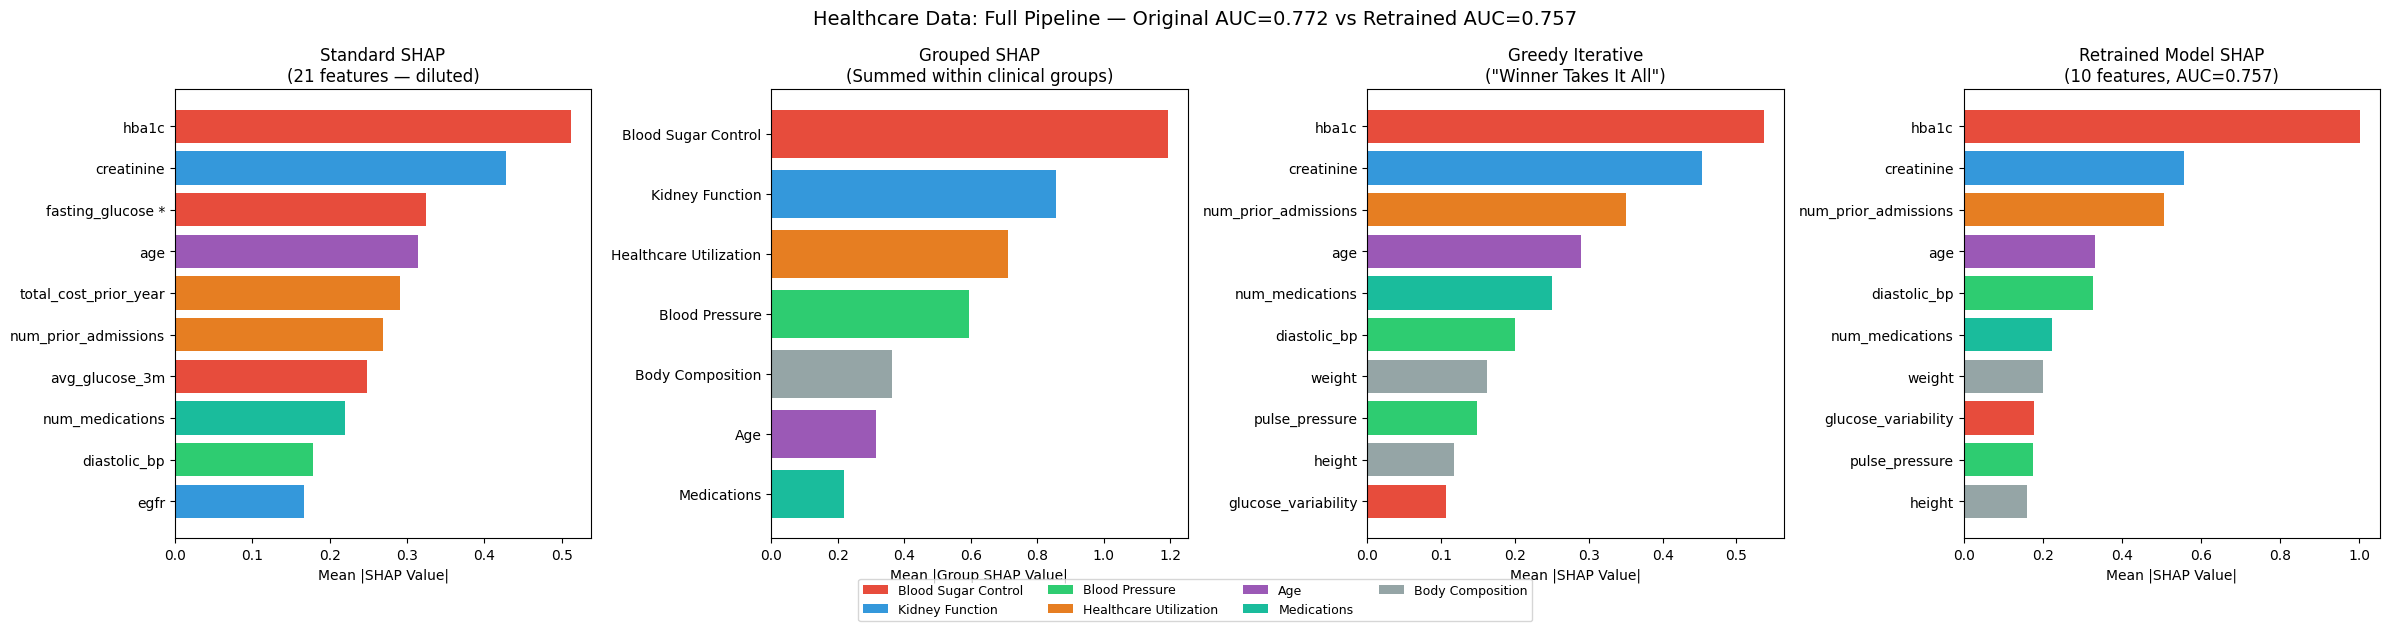

KEY INSIGHT:
  In Standard SHAP (panel 1), fasting_glucose appears as rank #3.
  In the Retrained Model (panel 4), fasting_glucose is GONE — not in the top features.
  Why? fasting_glucose is highly correlated with hba1c (corr ≈ 0.97).
  Greedy Iterative selected hba1c first (the 'winner'), conditioning out fasting_glucose.
  The retrained model without fasting_glucose has nearly the same AUC — it was redundant.


In [79]:
# Final comparison visualization for the healthcare data
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# 1. Standard SHAP — top 10 individual features
top_10 = feature_importance.head(10)
colors_std = []
for feat in top_10['feature']:
    for gname, gfeats in health_groups.items():
        if feat in gfeats:
            colors_std.append(group_color_map[gname])
            break

# Highlight fasting_glucose in standard SHAP
std_labels = []
for feat in top_10['feature']:
    if feat == 'fasting_glucose':
        std_labels.append(f'{feat} *')
    else:
        std_labels.append(feat)

axes[0].barh(range(10), top_10['mean_abs_shap'].values, color=colors_std)
axes[0].set_yticks(range(10))
axes[0].set_yticklabels(std_labels)
axes[0].set_title(f'Standard SHAP\n({len(feature_names_health)} features — diluted)')
axes[0].set_xlabel('Mean |SHAP Value|')
axes[0].invert_yaxis()

# 2. Grouped SHAP — summed within groups
group_colors = [group_color_map[g] for g in group_imp_df['group']]
axes[1].barh(range(len(group_imp_df)), group_imp_df['mean_abs_shap'].values, color=group_colors)
axes[1].set_yticks(range(len(group_imp_df)))
axes[1].set_yticklabels(group_imp_df['group'].values)
axes[1].set_title('Grouped SHAP\n(Summed within clinical groups)')
axes[1].set_xlabel('Mean |Group SHAP Value|')
axes[1].invert_yaxis()

# 3. Greedy Iterative — winner takes it all
if greedy_health_results:
    greedy_names = [r['name'] for r in greedy_health_results]
    greedy_vals = [r['mean_abs_shap'] for r in greedy_health_results]
    greedy_colors = []
    for feat in greedy_names:
        color = '#95a5a6'
        for gname, gfeats in health_groups.items():
            if feat in gfeats:
                color = group_color_map[gname]
                break
        greedy_colors.append(color)

    axes[2].barh(range(len(greedy_names)), greedy_vals, color=greedy_colors)
    axes[2].set_yticks(range(len(greedy_names)))
    axes[2].set_yticklabels(greedy_names)
    axes[2].set_title('Greedy Iterative\n("Winner Takes It All")')
    axes[2].set_xlabel('Mean |SHAP Value|')
    axes[2].invert_yaxis()

# 4. Retrained model SHAP — only selected features
retrained_colors = []
for feat in selected_importance['feature']:
    color = '#95a5a6'
    for gname, gfeats in health_groups.items():
        if feat in gfeats:
            color = group_color_map[gname]
            break
    retrained_colors.append(color)

axes[3].barh(range(len(selected_importance)), selected_importance['mean_abs_shap'].values,
             color=retrained_colors)
axes[3].set_yticks(range(len(selected_importance)))
axes[3].set_yticklabels(selected_importance['feature'].values)
axes[3].set_title(f'Retrained Model SHAP\n({len(selected_feature_names)} features, AUC={auc_selected:.3f})')
axes[3].set_xlabel('Mean |SHAP Value|')
axes[3].invert_yaxis()

# Legend
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor=c, label=g) for g, c in group_color_map.items()]
fig.legend(handles=legend_elements, loc='lower center', ncol=4,
           bbox_to_anchor=(0.5, -0.05), fontsize=9)

plt.suptitle(f'Healthcare Data: Full Pipeline — Original AUC={auc:.3f} vs Retrained AUC={auc_selected:.3f}',
             fontsize=14)
plt.tight_layout()
plt.show()

# Highlight the fasting_glucose finding
print("KEY INSIGHT:")
print("  In Standard SHAP (panel 1), fasting_glucose appears as rank #3.")
print("  In the Retrained Model (panel 4), fasting_glucose is GONE — not in the top features.")
print("  Why? fasting_glucose is highly correlated with hba1c (corr ≈ 0.97).")
print("  Greedy Iterative selected hba1c first (the 'winner'), conditioning out fasting_glucose.")
print("  The retrained model without fasting_glucose has nearly the same AUC — it was redundant.")

---
## Part 6: Summary & Key Takeaways

### What We Learned

| Problem | Standard SHAP | Grouped SHAP | Greedy Iterative |
|---------|--------------|--------------|------------------|
| Duplicated features | Signal diluted evenly | Recovered by summing within group | Winner gets all credit (with corr conditioning) |
| Correlated features | Credit split "fairly" | Grouped by domain knowledge | Auto-discovers redundancy via correlation |
| Computational cost | O(2^N) / approximated | O(2^G) for direct, O(N) for sum | O(K × SHAP) for K steps |
| Requires domain knowledge | No | Yes (need to define groups) | No (uses correlation threshold) |

### Model-Dependent Behavior

A key finding from our experiments: **SHAP dilution depends on the model + data combination**:

| | Linear Regression | LGBM (Tree-based) |
|---|---|---|
| **Perfect duplicates** | Diluted (OLS spreads weights) | Not diluted (deterministic tie-breaking) |
| **Noisy duplicates** | Not diluted (OLS finds clean signal) | Diluted (different trees use different copies) |

This means no single SHAP method works universally — the choice depends on your model and feature correlation structure.

### Full Pipeline (Healthcare Example)

1. **Standard SHAP** on full model → identify that dilution is present
2. **Grouped SHAP** → recover signal if domain groups are known
3. **Greedy Iterative** → auto-select representative features (with `corr_threshold` to condition correlated features)
4. **Retrain model** on selected features → clean SHAP with minimal AUC loss

### When to Use What

1. **Standard SHAP** — Use when features are reasonably independent, or for initial exploration
2. **Summed Group SHAP** — Use when you have domain knowledge about feature groups. Simple, fast, and usually good enough
3. **Direct Group Shapley** — Use when within-group interactions matter and you have few groups (< 15)
4. **Greedy Iterative** — Use when you don't have group definitions. Best with tree-based models. The `corr_threshold` parameter is critical for propagating conditioning to correlated features

### The CMS Challenge Connection

In the [CMS AI Health Outcomes Challenge](https://www.closedloop.ai/cms-challenge/), models used hundreds of clinical features with strong correlations:
- Multiple lab tests measuring the same biological process
- Rolling averages, lags, and transformations of vitals
- Claims-based features derived from the same encounters

Alon Lanyado (Medial EarlySign) applied **Grouped Shapley with Winner Takes It All** in this setting. In blinded evaluations, clinicians preferred this method over vanilla SHAP values because it correctly surfaced the *concepts* driving predictions rather than splitting credit across redundant features.

### References

- [When Shapley Values Break: A Guide to Robust Model Explainability](https://towardsdatascience.com/when-shapley-values-break-a-guide-to-robust-model-explainability/) — Alon Lanyado, Towards Data Science (2026)
- [SHAP: A Unified Approach to Interpreting Model Predictions](https://github.com/shap/shap) — Lundberg & Lee
- [CMS AI Health Outcomes Challenge](https://www.closedloop.ai/cms-challenge/) — ClosedLoop.ai (winner)
- [Interpretable ML Book — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html) — Christoph Molnar

### Note on `medpython`

The original article references the `medpython` package from Medial EarlySign, which contains production implementations of these methods. As of this writing, `medpython` is not publicly available on PyPI — it appears to be an internal/proprietary tool. The implementations in this notebook are faithful standalone reimplementations of the concepts described in the article.